In [1]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
import csv
import numpy as np
import os.path
import seaborn as sns
import statistics

In [2]:
plt.rcParams["figure.figsize"] = [10.00, 5.00]
plt.rcParams["figure.autolayout"] = True

In [3]:
RUNS_PER_CONFIG = 5
FRAMES_PER_RUN = 250
FRAMES_PER_RUN_RPI = 50
pathX86 = "./benchmarks_x86/"
pathRpi = "./benchmarks_rpi/"
x86Cores = [1, 2, 4, 8, 16]
RpiCores = [1, 2, 4]

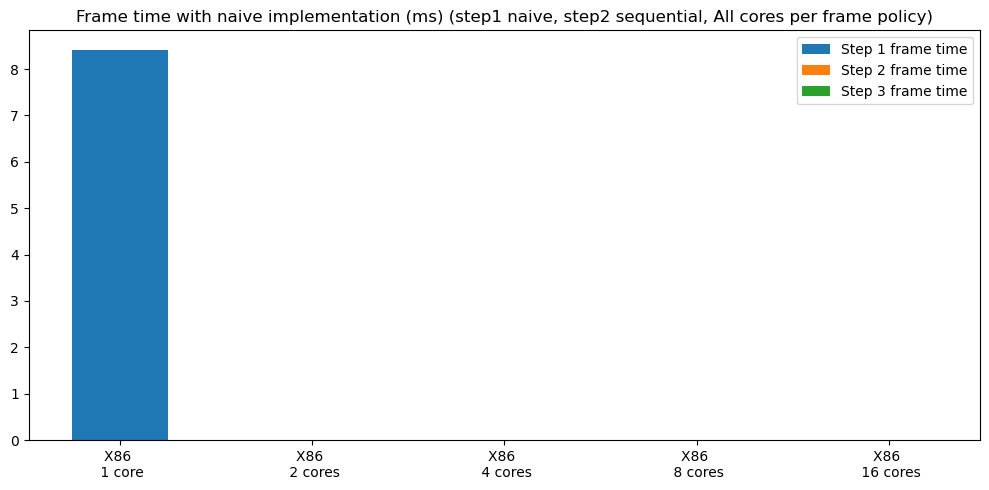

In [5]:
# introduction benchmark
dataIntroX86 = {}
for c in x86Cores:
    dataIntroX86[c] = {}
    dataIntroX86[c]["s1"] = 0.0
    dataIntroX86[c]["s2"] = 0.0
    dataIntroX86[c]["s3"] = 0.0
    dataIntroX86[c]["realTiming"] = 0.0
    
with open(pathX86 + "complete_benchmark/INTRO_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataIntroX86[int(row["CORE_COUNT"])]["s1"] += float(row["step1Timing"])
        dataIntroX86[int(row["CORE_COUNT"])]["s2"] += float(row["step3Timing"])
        dataIntroX86[int(row["CORE_COUNT"])]["s3"] += float(row["step2Timing"])

with open(pathX86 + "complete_benchmark/INTRO_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataIntroX86[int(row["CORE_COUNT"])]["realTiming"] += float(row["realTiming"])
        
for c in x86Cores:
    dataIntroX86[c]["s1"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
    dataIntroX86[c]["s2"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
    dataIntroX86[c]["s3"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
    dataIntroX86[c]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "X86 \n 1 core",
    "X86 \n 2 cores",
    "X86 \n 4 cores",
    "X86 \n 8 cores",
    "X86 \n 16 cores",
)
weight_counts = {
    "Step 1 frame time": np.array([dataIntroX86[i]["s1"] for i in x86Cores]),
    "Step 2 frame time": np.array([dataIntroX86[i]["s2"] for i in x86Cores]),
    "Step 3 frame time": np.array([dataIntroX86[i]["s3"] for i in x86Cores]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(1*len(x86Cores))

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Frame time with naive implementation (ms) (step1 naive, step2 sequential, All cores per frame policy)")
ax.legend(loc="upper right")

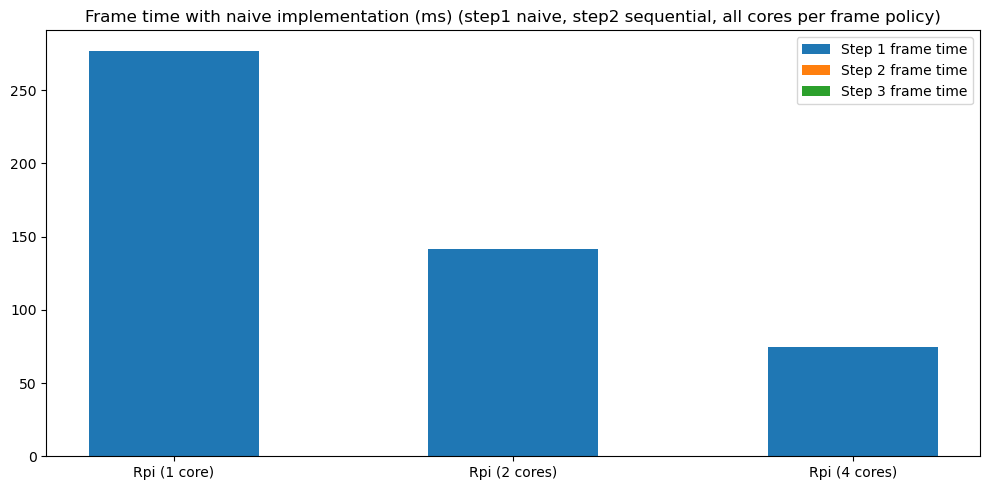

In [6]:
# introduction benchmark
dataIntroRpi = {}
for c in RpiCores:
    dataIntroRpi[c] = {}
    dataIntroRpi[c]["s1"] = 0.0
    dataIntroRpi[c]["s2"] = 0.0
    dataIntroRpi[c]["s3"] = 0.0
    dataIntroRpi[c]["realTiming"] = 0.0
    
with open(pathRpi + "complete_benchmark/INTRO_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataIntroRpi[int(row["CORE_COUNT"])]["s1"] += float(row["step1Timing"])
        dataIntroRpi[int(row["CORE_COUNT"])]["s2"] += float(row["step3Timing"])
        dataIntroRpi[int(row["CORE_COUNT"])]["s3"] += float(row["step2Timing"])

with open(pathRpi + "complete_benchmark/INTRO_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataIntroRpi[int(row["CORE_COUNT"])]["realTiming"] += float(row["realTiming"])

for c in RpiCores:
    dataIntroRpi[c]["s1"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
    dataIntroRpi[c]["s2"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
    dataIntroRpi[c]["s3"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
    dataIntroRpi[c]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "Rpi (1 core)",
    "Rpi (2 cores)",
    "Rpi (4 cores)"
)
weight_counts = {
    "Step 1 frame time": np.array([dataIntroRpi[i]["s1"] for i in RpiCores]),
    "Step 2 frame time": np.array([dataIntroRpi[i]["s2"] for i in RpiCores]),
    "Step 3 frame time": np.array([dataIntroRpi[i]["s3"] for i in RpiCores]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(1*len(RpiCores))

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Frame time with naive implementation (ms) (step1 naive, step2 sequential, all cores per frame policy)")
ax.legend(loc="upper right")

# plt.savefig("figures/intro.png")

In [7]:
s1X86 = {}
algos = ["naive", "optimized", "simplified"]
for c in x86Cores:
    s1X86[c] = {}
    for algo in algos:
        s1X86[c][algo] = {}
        s1X86[c][algo]["T1Timing"] = 0.0
        s1X86[c][algo]["T2Timing"] = 0.0
        s1X86[c][algo]["T3Timing"] = 0.0
        s1X86[c][algo]["T4Timing"] = 0.0
        s1X86[c][algo]["T5Timing"] = 0.0
        s1X86[c][algo]["T6Timing"] = 0.0
        s1X86[c][algo]["extractionTiming"] = 0.0
        s1X86[c][algo]["filteringTiming"] = 0.0
        s1X86[c][algo]["waitingTiming"] = 0.0
    
with open(pathX86 + "step1/NAIVE_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "naive"
    for row in reader:
        s1X86[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        
with open(pathX86 + "step1/OPTIMIZED_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "optimized"
    for row in reader:
        s1X86[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        
with open(pathX86 + "step1/SIMPLIFIED_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "simplified"
    for row in reader:
        s1X86[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1X86[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1X86[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])

for c in x86Cores:
    for algo in algos:
        s1X86[c][algo]["T1Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["T2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["T3Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["T4Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["T5Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["T6Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["extractionTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["filteringTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s1X86[c][algo]["waitingTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "naive \n x86 \n 2 cores",
    "naive \n x86 \n 4 cores",
    "naive \n x86 \n 8 cores",
    "optimized \n x86 \n 2 cores",
    "optimized \n x86 \n 4 cores",
    "optimized \n x86 \n 8 cores",
    "simplified \n x86 \n 2 cores",
    "simplified \n x86 \n 4 cores",
    "simplified \n x86 \n 8 cores",
)
weight_counts = {
    "T1": np.array([s1X86[c]["naive"]["T1Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T1Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T1Timing"] for c in [2, 4, 8]]),
    "T2": np.array([s1X86[c]["naive"]["T2Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T2Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T2Timing"] for c in [2, 4, 8]]),
    "T3": np.array([s1X86[c]["naive"]["T3Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T3Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T3Timing"] for c in [2, 4, 8]]),
    "T4": np.array([s1X86[c]["naive"]["T4Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T4Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T4Timing"] for c in [2, 4, 8]]),
    "T5": np.array([s1X86[c]["naive"]["T5Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T5Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T5Timing"] for c in [2, 4, 8]]),
    "T6": np.array([s1X86[c]["naive"]["T6Timing"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["T6Timing"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["T6Timing"] for c in [2, 4, 8]]),
    "extraction of bees": np.array([s1X86[c]["naive"]["extractionTiming"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["extractionTiming"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["extractionTiming"] for c in [2, 4, 8]]),
    "filtering and preprocessing": np.array([s1X86[c]["naive"]["filteringTiming"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["filteringTiming"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["filteringTiming"] for c in [2, 4, 8]]),
    "threads wait time": np.array([s1X86[c]["naive"]["waitingTiming"] for c in [2, 4, 8]] + 
                   [s1X86[c]["optimized"]["waitingTiming"] for c in [2, 4, 8]] +
                   [s1X86[c]["simplified"]["waitingTiming"] for c in [2, 4, 8]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Portion of frame time latency occupied by step 1 depending on the algorithm (ms)")
ax.legend(loc="upper right")

FileNotFoundError: [Errno 2] No such file or directory: './benchmarks_x86/step1/NAIVE_step1InternalTimings.csv'

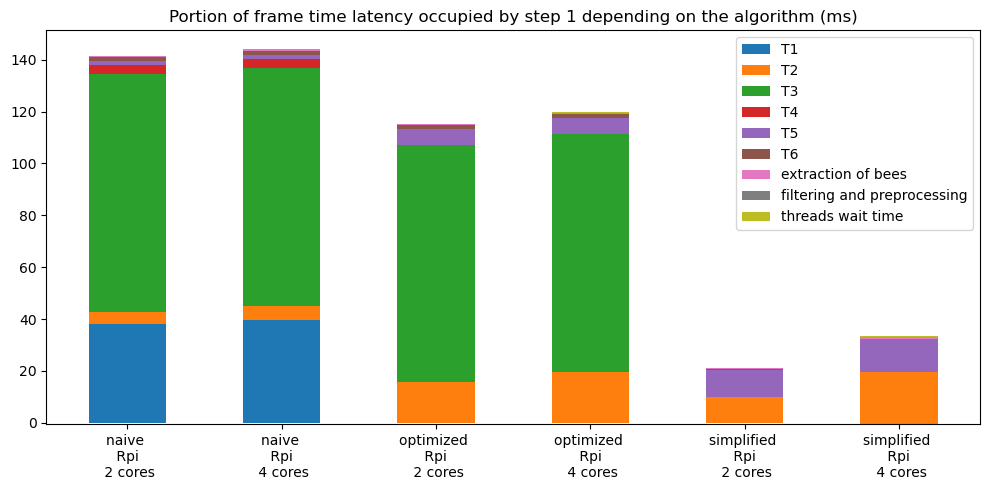

In [9]:
s1Rpi = {}
algos = ["naive", "optimized", "simplified"]
for c in RpiCores:
    s1Rpi[c] = {}
    for algo in algos:
        s1Rpi[c][algo] = {}
        s1Rpi[c][algo]["T1Timing"] = 0.0
        s1Rpi[c][algo]["T2Timing"] = 0.0
        s1Rpi[c][algo]["T3Timing"] = 0.0
        s1Rpi[c][algo]["T4Timing"] = 0.0
        s1Rpi[c][algo]["T5Timing"] = 0.0
        s1Rpi[c][algo]["T6Timing"] = 0.0
        s1Rpi[c][algo]["extractionTiming"] = 0.0
        s1Rpi[c][algo]["filteringTiming"] = 0.0
        s1Rpi[c][algo]["waitingTiming"] = 0.0
    
with open(pathRpi + "step1/NAIVE_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "naive"
    for row in reader:
        s1Rpi[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        
with open(pathRpi + "step1/OPTIMIZED_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "optimized"
    for row in reader:
        s1Rpi[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        
with open(pathRpi + "step1/SIMPLIFIED_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "simplified"
    for row in reader:
        s1Rpi[int(row["CORE_COUNT"])][algo]["T1Timing"] += float(row["T1Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T2Timing"] += float(row["T2Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T3Timing"] += float(row["T3Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T4Timing"] += float(row["T4Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T5Timing"] += float(row["T5Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["T6Timing"] += float(row["T6Timing"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["extractionTiming"] += float(row["extractionTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["filteringTiming"] += float(row["filteringTiming"])
        s1Rpi[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])

for c in RpiCores:
    for algo in algos:
        s1Rpi[c][algo]["T1Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["T2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["T3Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["T4Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["T5Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["T6Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["extractionTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["filteringTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s1Rpi[c][algo]["waitingTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "naive \n Rpi \n 2 cores",
    "naive \n Rpi \n 4 cores",
    "optimized \n Rpi \n 2 cores",
    "optimized \n Rpi \n 4 cores",
    "simplified \n Rpi \n 2 cores",
    "simplified \n Rpi \n 4 cores",
)
weight_counts = {
    "T1": np.array([s1Rpi[c]["naive"]["T1Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T1Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T1Timing"] for c in [2, 4]]),
    "T2": np.array([s1Rpi[c]["naive"]["T2Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T2Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T2Timing"] for c in [2, 4]]),
    "T3": np.array([s1Rpi[c]["naive"]["T3Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T3Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T3Timing"] for c in [2, 4]]),
    "T4": np.array([s1Rpi[c]["naive"]["T4Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T4Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T4Timing"] for c in [2, 4]]),
    "T5": np.array([s1Rpi[c]["naive"]["T5Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T5Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T5Timing"] for c in [2, 4]]),
    "T6": np.array([s1Rpi[c]["naive"]["T6Timing"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["T6Timing"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["T6Timing"] for c in [2, 4]]),
    "extraction of bees": np.array([s1Rpi[c]["naive"]["extractionTiming"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["extractionTiming"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["extractionTiming"] for c in [2, 4]]),
    "filtering and preprocessing": np.array([s1Rpi[c]["naive"]["filteringTiming"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["filteringTiming"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["filteringTiming"] for c in [2, 4]]),
    "threads wait time": np.array([s1Rpi[c]["naive"]["waitingTiming"] for c in [2, 4]] + 
                   [s1Rpi[c]["optimized"]["waitingTiming"] for c in [2, 4]] +
                   [s1Rpi[c]["simplified"]["waitingTiming"] for c in [2, 4]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Portion of frame time latency occupied by step 1 depending on the algorithm (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/step1.png")

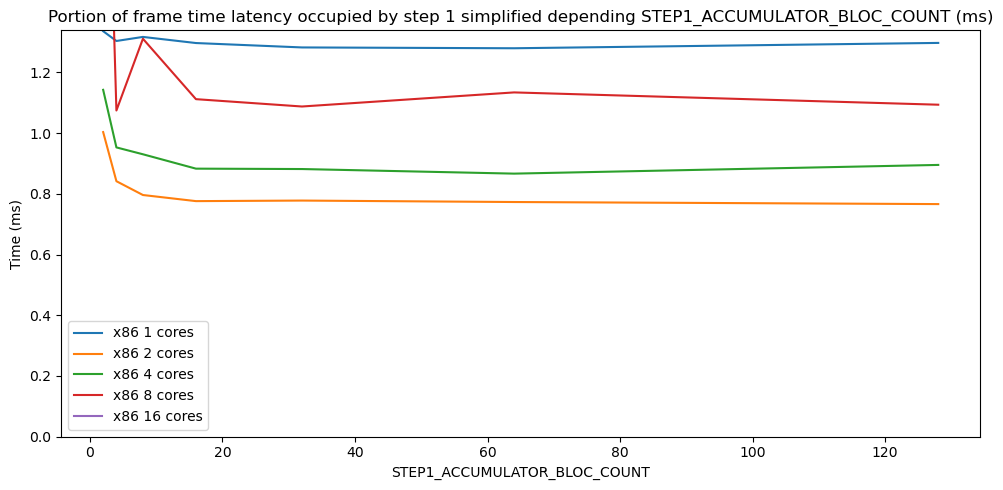

In [8]:
s1AccBlocsX86 = {}
for c in x86Cores:
    s1AccBlocsX86[c] = {}

with open(pathX86 + "step1/SIMPLIFIED_ACCUMULATOR_BLOCS_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["STEP1_ACCUMULATOR_BLOC_COUNT"]) not in s1AccBlocsX86[int(row["CORE_COUNT"])].keys()) :
            s1AccBlocsX86[int(row["CORE_COUNT"])][int(row["STEP1_ACCUMULATOR_BLOC_COUNT"])] = 0
        s1AccBlocsX86[int(row["CORE_COUNT"])][int(row["STEP1_ACCUMULATOR_BLOC_COUNT"])] += float(row["step1Timing"])

plt.figure()
for c in x86Cores:
    x86x = [i for i in s1AccBlocsX86[c].keys()]
    x86x.sort()
    x86y = [s1AccBlocsX86[c][i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN) for i in x86x]
    plt.plot(x86x, x86y, label="x86 " + str(c) + " cores")
    plt.ylim(0)
plt.title("Portion of frame time latency occupied by step 1 simplified depending STEP1_ACCUMULATOR_BLOC_COUNT (ms)")
plt.xlabel('STEP1_ACCUMULATOR_BLOC_COUNT')
plt.ylabel('Time (ms)')
plt.legend()

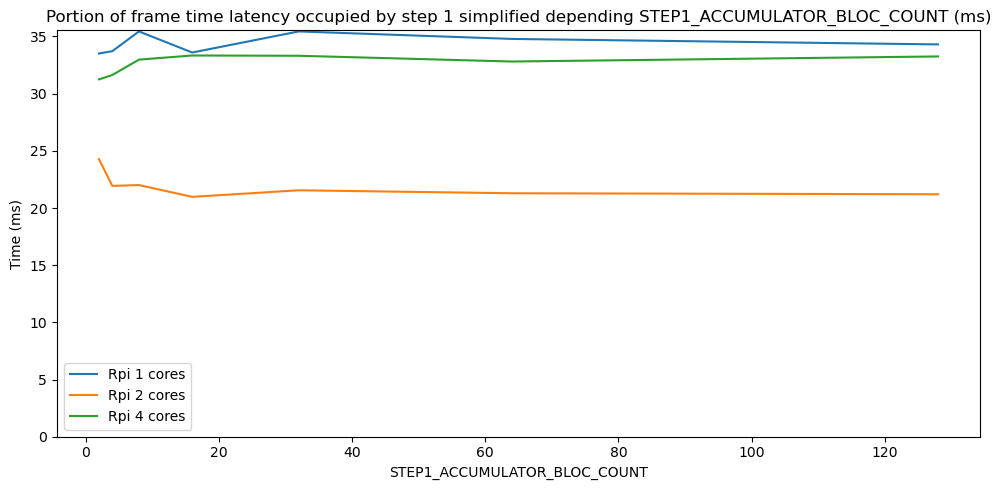

In [10]:
s1AccBlocsRpi = {}
for c in RpiCores:
    s1AccBlocsRpi[c] = {}

with open(pathRpi + "step1/SIMPLIFIED_ACCUMULATOR_BLOCS_step1InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["STEP1_ACCUMULATOR_BLOC_COUNT"]) not in s1AccBlocsRpi[int(row["CORE_COUNT"])].keys()) :
            s1AccBlocsRpi[int(row["CORE_COUNT"])][int(row["STEP1_ACCUMULATOR_BLOC_COUNT"])] = 0
        s1AccBlocsRpi[int(row["CORE_COUNT"])][int(row["STEP1_ACCUMULATOR_BLOC_COUNT"])] += float(row["step1Timing"])

plt.figure()
for c in RpiCores:
    Rpix = [i for i in s1AccBlocsRpi[c].keys()]
    Rpix.sort()
    Rpiy = [s1AccBlocsRpi[c][i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI) for i in Rpix]
    plt.plot(Rpix, Rpiy, label="Rpi " + str(c) + " cores")
    plt.ylim(0)
plt.title("Portion of frame time latency occupied by step 1 simplified depending STEP1_ACCUMULATOR_BLOC_COUNT (ms)")
plt.xlabel('STEP1_ACCUMULATOR_BLOC_COUNT')
plt.ylabel('Time (ms)')
plt.legend()

# plt.savefig("figures/frame_accu_blocs.png")

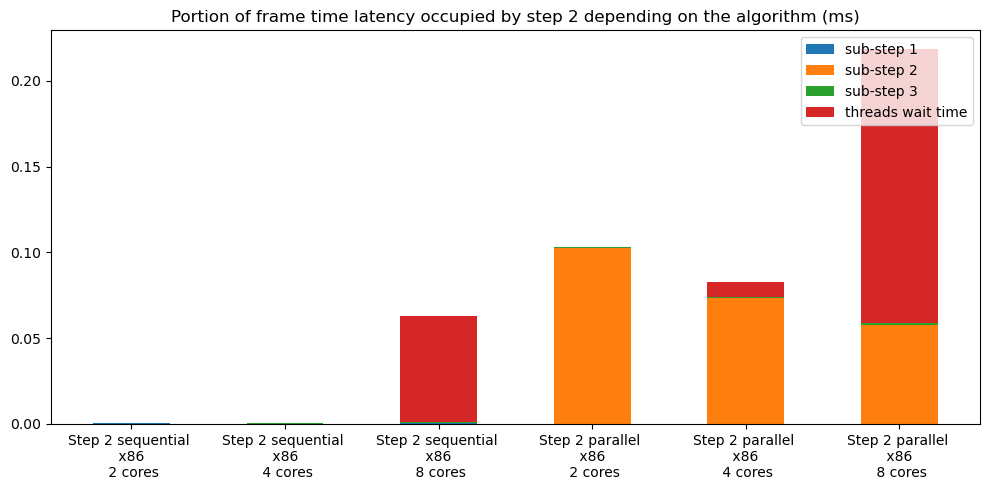

In [10]:
s2X86 = {}
algos = ["sequential", "parallel"]
for c in x86Cores:
    s2X86[c] = {}
    for algo in algos:
        s2X86[c][algo] = {}
        s2X86[c][algo]["subStep1Timing"] = 0.0
        s2X86[c][algo]["subStep2Timing"] = 0.0
        s2X86[c][algo]["subStep3Timing"] = 0.0
        s2X86[c][algo]["waitingTiming"] = 0.0
        s2X86[c][algo]["step2Timing"] = 0.0
    
with open(pathX86 + "step2/SEQUENTIAL_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "sequential"
    for row in reader:
        s2X86[int(row["CORE_COUNT"])][algo]["subStep1Timing"] += float(row["subStep1Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["subStep2Timing"] += float(row["subStep2Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["subStep3Timing"] += float(row["subStep3Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        s2X86[int(row["CORE_COUNT"])][algo]["step2Timing"] += float(row["step2Timing"])
        
with open(pathX86 + "step2/PARALLEL_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "parallel"
    for row in reader:
        s2X86[int(row["CORE_COUNT"])][algo]["subStep1Timing"] += float(row["subStep1Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["subStep2Timing"] += float(row["subStep2Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["subStep3Timing"] += float(row["subStep3Timing"])
        s2X86[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        s2X86[int(row["CORE_COUNT"])][algo]["step2Timing"] += float(row["step2Timing"])

for c in x86Cores:
    for algo in algos:
        s2X86[c][algo]["subStep1Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s2X86[c][algo]["subStep2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s2X86[c][algo]["subStep3Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s2X86[c][algo]["waitingTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        s2X86[c][algo]["step2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "Step 2 sequential \n x86 \n 2 cores",
    "Step 2 sequential \n x86 \n 4 cores",
    "Step 2 sequential \n x86 \n 8 cores",
    "Step 2 parallel \n x86 \n 2 cores",
    "Step 2 parallel \n x86 \n 4 cores",
    "Step 2 parallel \n x86 \n 8 cores",
)
weight_counts = {
    "sub-step 1": np.array([s2X86[c]["sequential"]["subStep1Timing"] for c in [2, 4, 8]] +
                           [s2X86[c]["parallel"]["subStep1Timing"] for c in [2, 4, 8]]),
    "sub-step 2": np.array([s2X86[c]["sequential"]["subStep2Timing"] for c in [2, 4, 8]] +
                           [s2X86[c]["parallel"]["subStep2Timing"] for c in [2, 4, 8]]),
    "sub-step 3": np.array([s2X86[c]["sequential"]["subStep3Timing"] for c in [2, 4, 8]] +
                           [s2X86[c]["parallel"]["subStep3Timing"] for c in [2, 4, 8]]),
    "threads wait time": np.array([s2X86[c]["sequential"]["waitingTiming"] for c in [2, 4, 8]] +
                                  [s2X86[c]["parallel"]["waitingTiming"] for c in [2, 4, 8]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2*3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Portion of frame time latency occupied by step 2 depending on the algorithm (ms)")
ax.legend(loc="upper right")

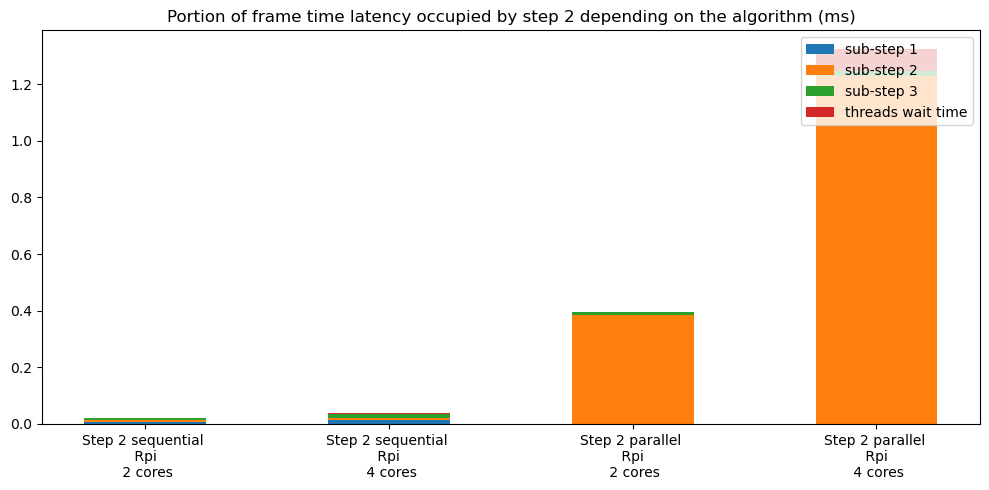

In [11]:
s2Rpi = {}
algos = ["sequential", "parallel"]
for c in RpiCores:
    s2Rpi[c] = {}
    for algo in algos:
        s2Rpi[c][algo] = {}
        s2Rpi[c][algo]["subStep1Timing"] = 0.0
        s2Rpi[c][algo]["subStep2Timing"] = 0.0
        s2Rpi[c][algo]["subStep3Timing"] = 0.0
        s2Rpi[c][algo]["waitingTiming"] = 0.0
        s2Rpi[c][algo]["step2Timing"] = 0.0
    
with open(pathRpi + "step2/SEQUENTIAL_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "sequential"
    for row in reader:
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep1Timing"] += float(row["subStep1Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep2Timing"] += float(row["subStep2Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep3Timing"] += float(row["subStep3Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["step2Timing"] += float(row["step2Timing"])
        
with open(pathRpi + "step2/PARALLEL_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "parallel"
    for row in reader:
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep1Timing"] += float(row["subStep1Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep2Timing"] += float(row["subStep2Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["subStep3Timing"] += float(row["subStep3Timing"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["waitingTiming"] += float(row["waitingTiming"])
        s2Rpi[int(row["CORE_COUNT"])][algo]["step2Timing"] += float(row["step2Timing"])

for c in RpiCores:
    for algo in algos:
        s2Rpi[c][algo]["subStep1Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s2Rpi[c][algo]["subStep2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s2Rpi[c][algo]["subStep3Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s2Rpi[c][algo]["waitingTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        s2Rpi[c][algo]["step2Timing"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "Step 2 sequential \n Rpi \n 2 cores",
    "Step 2 sequential \n Rpi \n 4 cores",
    "Step 2 parallel \n Rpi \n 2 cores",
    "Step 2 parallel \n Rpi \n 4 cores"
)
weight_counts = {
    "sub-step 1": np.array([s2Rpi[c]["sequential"]["subStep1Timing"] for c in [2, 4]] +
                           [s2Rpi[c]["parallel"]["subStep1Timing"] for c in [2, 4]]),
    "sub-step 2": np.array([s2Rpi[c]["sequential"]["subStep2Timing"] for c in [2, 4]] +
                           [s2Rpi[c]["parallel"]["subStep2Timing"] for c in [2, 4]]),
    "sub-step 3": np.array([s2Rpi[c]["sequential"]["subStep3Timing"] for c in [2, 4]] +
                           [s2Rpi[c]["parallel"]["subStep3Timing"] for c in [2, 4]]),
    "threads wait time": np.array([s2Rpi[c]["sequential"]["waitingTiming"] for c in [2, 4]] +
                                  [s2Rpi[c]["parallel"]["waitingTiming"] for c in [2, 4]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Portion of frame time latency occupied by step 2 depending on the algorithm (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/step2.png")

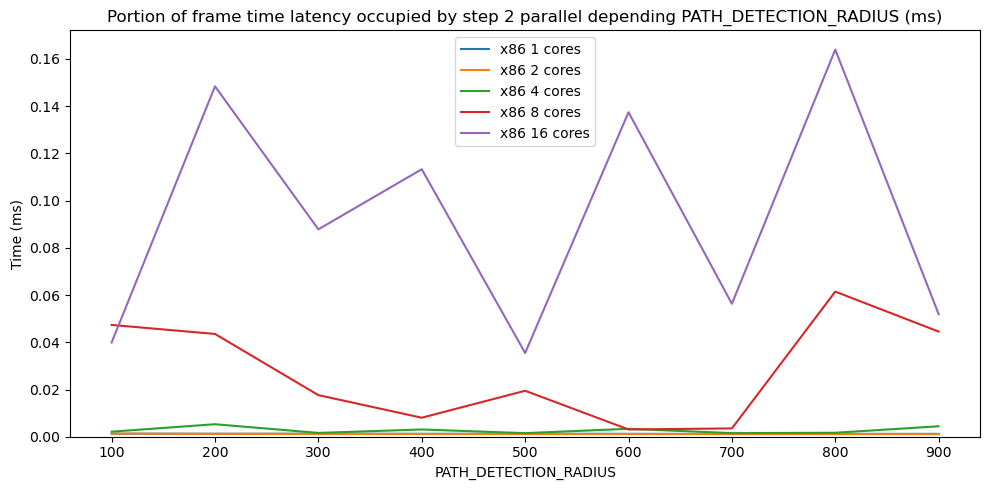

In [12]:
s1RadiusX86 = {}
for c in x86Cores:
    s1RadiusX86[c] = {}

with open(pathX86 + "step2/PARALLEL_RADIUS_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["PATH_DETECTION_RADIUS"]) not in s1RadiusX86[int(row["CORE_COUNT"])].keys()) :
            s1RadiusX86[int(row["CORE_COUNT"])][int(float(row["PATH_DETECTION_RADIUS"]))] = 0
        s1RadiusX86[int(row["CORE_COUNT"])][int(float(row["PATH_DETECTION_RADIUS"]))] += float(row["step2Timing"])
        
plt.figure()
for c in x86Cores:
    x86x = [i for i in s1RadiusX86[c].keys()]
    x86x.sort()
    x86y = [s1RadiusX86[c][i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN) for i in x86x]
    plt.plot(x86x, x86y, label="x86 " + str(c) + " cores")
plt.ylim(0)
plt.title("Portion of frame time latency occupied by step 2 parallel depending PATH_DETECTION_RADIUS (ms)")
plt.xlabel('PATH_DETECTION_RADIUS')
plt.ylabel('Time (ms)')
plt.legend()

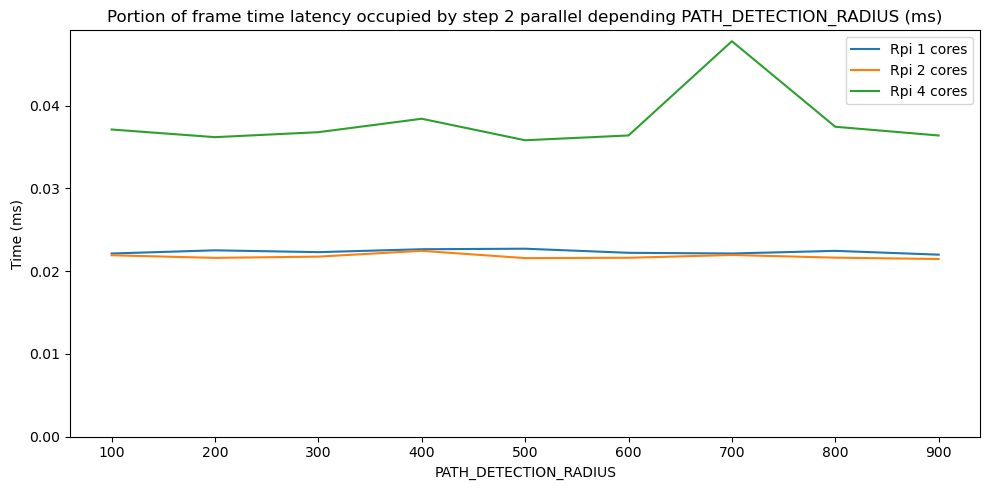

In [13]:
s1RadiusRpi = {}
for c in RpiCores:
    s1RadiusRpi[c] = {}

with open(pathRpi + "step2/PARALLEL_RADIUS_step2InternalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["PATH_DETECTION_RADIUS"]) not in s1RadiusRpi[int(row["CORE_COUNT"])].keys()) :
            s1RadiusRpi[int(row["CORE_COUNT"])][int(float(row["PATH_DETECTION_RADIUS"]))] = 0
        s1RadiusRpi[int(row["CORE_COUNT"])][int(float(row["PATH_DETECTION_RADIUS"]))] += float(row["step2Timing"])
        
plt.figure()
for c in RpiCores:
    Rpix = [i for i in s1RadiusRpi[c].keys()]
    Rpix.sort()
    Rpiy = [s1RadiusRpi[c][i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI) for i in Rpix]
    plt.plot(Rpix, Rpiy, label="Rpi " + str(c) + " cores")
plt.ylim(0)
plt.title("Portion of frame time latency occupied by step 2 parallel depending PATH_DETECTION_RADIUS (ms)")
plt.xlabel('PATH_DETECTION_RADIUS')
plt.ylabel('Time (ms)')
plt.legend()

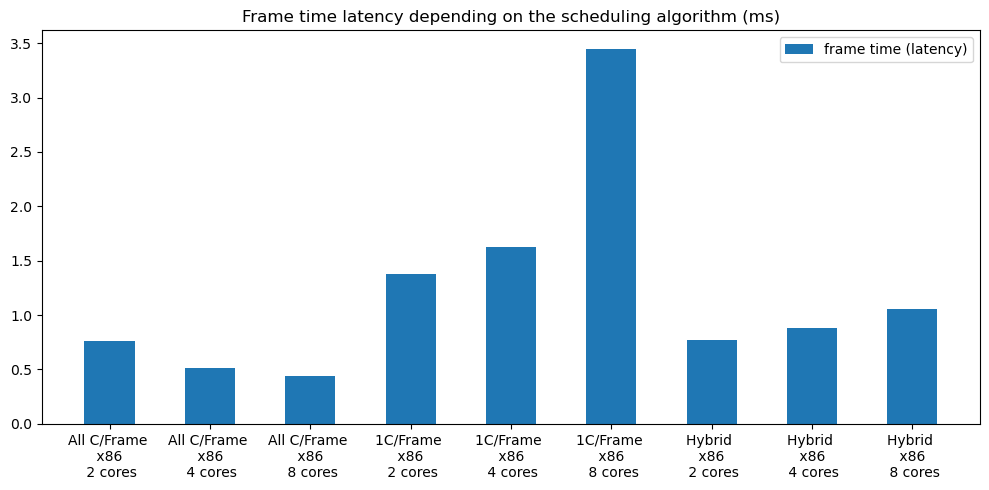

In [14]:
scheduX86 = {}
for c in x86Cores:
    scheduX86[c] = {}
    
algos = ["allCoresAllFrames", "oneCorePerFrame", "hybrid"]
for c in x86Cores:
    for algo in algos:
        scheduX86[c][algo] = {}
        scheduX86[c][algo]["frameTiming"] = 0.0
        scheduX86[c][algo]["realTiming"] = 0.0
    
with open(pathX86 + "scheduling/ALL_CORE_EACH_FRAME_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "allCoresAllFrames"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "scheduling/ONE_CORE_PER_FRAME_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "oneCorePerFrame"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "scheduling/HYBRID_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "hybrid"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "scheduling/ALL_CORE_EACH_FRAME_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "allCoresAllFrames"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])
        
with open(pathX86 + "scheduling/ONE_CORE_PER_FRAME_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "oneCorePerFrame"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])
        
with open(pathX86 + "scheduling/HYBRID_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "hybrid"
    for row in reader:
        scheduX86[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])

for c in x86Cores:
    for algo in algos:
        scheduX86[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
        scheduX86[c][algo]["frameTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "All C/Frame \n x86 \n 2 cores",
    "All C/Frame \n x86 \n 4 cores",
    "All C/Frame \n x86 \n 8 cores",
    "1C/Frame \n x86 \n 2 cores",
    "1C/Frame \n x86 \n 4 cores",
    "1C/Frame \n x86 \n 8 cores",
    "Hybrid \n x86 \n 2 cores",
    "Hybrid \n x86 \n 4 cores",
    "Hybrid \n x86 \n 8 cores"
)
weight_counts = {
    "frame time (latency)": np.array([scheduX86[c]["allCoresAllFrames"]["frameTiming"] for c in [2, 4, 8]] + 
                                     [scheduX86[c]["oneCorePerFrame"]["frameTiming"] for c in [2, 4, 8]] +
                                     [scheduX86[c]["hybrid"]["frameTiming"] for c in [2, 4, 8]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Frame time latency depending on the scheduling algorithm (ms)")
ax.legend(loc="upper right")

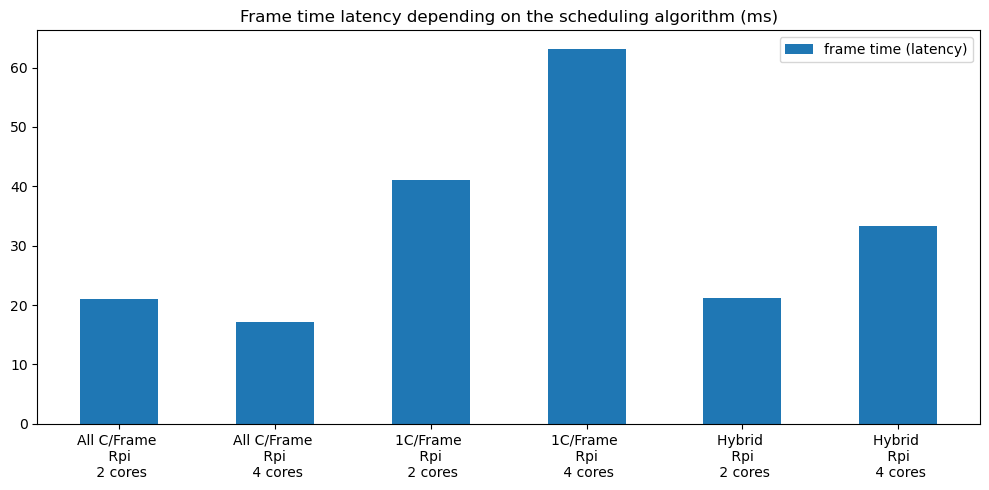

In [12]:
scheduRpi = {}
for c in RpiCores:
    scheduRpi[c] = {}
    
algos = ["allCoresAllFrames", "oneCorePerFrame", "hybrid"]
for c in RpiCores:
    for algo in algos:
        scheduRpi[c][algo] = {}
        scheduRpi[c][algo]["frameTiming"] = 0.0
        scheduRpi[c][algo]["realTiming"] = 0.0
    
with open(pathRpi + "scheduling/ALL_CORE_EACH_FRAME_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "allCoresAllFrames"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "scheduling/ONE_CORE_PER_FRAME_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "oneCorePerFrame"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "scheduling/HYBRID_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "hybrid"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "scheduling/ALL_CORE_EACH_FRAME_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "allCoresAllFrames"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])
        
with open(pathRpi + "scheduling/ONE_CORE_PER_FRAME_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "oneCorePerFrame"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])
        
with open(pathRpi + "scheduling/HYBRID_framesTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "hybrid"
    for row in reader:
        scheduRpi[int(row["CORE_COUNT"])][algo]["frameTiming"] += float(row["frameTiming"])
        
for c in RpiCores:
    for algo in algos:
        scheduRpi[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
        scheduRpi[c][algo]["frameTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "All C/Frame \n Rpi \n 2 cores",
    "All C/Frame \n Rpi \n 4 cores",
    "1C/Frame \n Rpi \n 2 cores",
    "1C/Frame \n Rpi \n 4 cores",
    "Hybrid \n Rpi \n 2 cores",
    "Hybrid \n Rpi \n 4 cores"
)
weight_counts = {
    "frame time (latency)": np.array([scheduRpi[c]["allCoresAllFrames"]["frameTiming"] for c in [2, 4]] + 
                                     [scheduRpi[c]["oneCorePerFrame"]["frameTiming"] for c in [2, 4]] +
                                     [scheduRpi[c]["hybrid"]["frameTiming"] for c in [2, 4]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Frame time latency depending on the scheduling algorithm (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/scheduling.png")

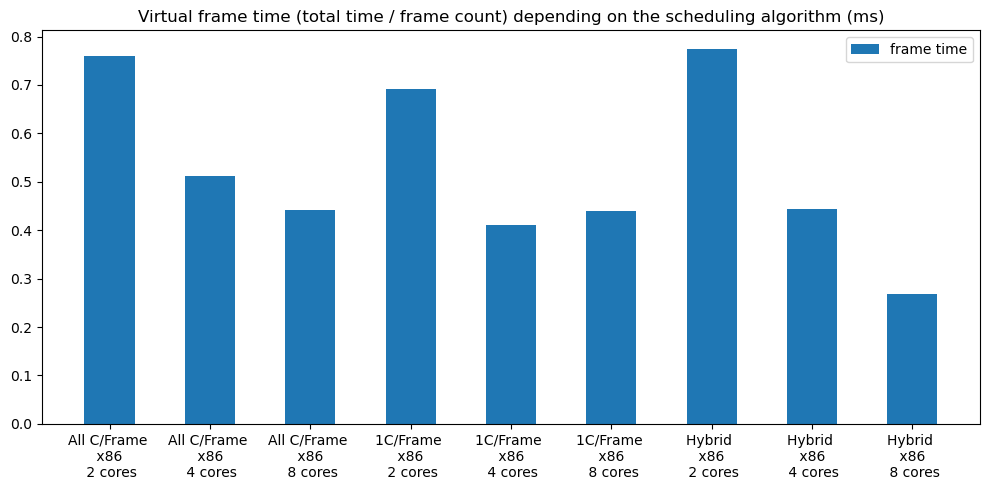

In [16]:
species = (
    "All C/Frame \n x86 \n 2 cores",
    "All C/Frame \n x86 \n 4 cores",
    "All C/Frame \n x86 \n 8 cores",
    "1C/Frame \n x86 \n 2 cores",
    "1C/Frame \n x86 \n 4 cores",
    "1C/Frame \n x86 \n 8 cores",
    "Hybrid \n x86 \n 2 cores",
    "Hybrid \n x86 \n 4 cores",
    "Hybrid \n x86 \n 8 cores"
)
weight_counts = {
    "frame time": np.array([scheduX86[c]["allCoresAllFrames"]["realTiming"] for c in [2, 4, 8]] + 
                                     [scheduX86[c]["oneCorePerFrame"]["realTiming"] for c in [2, 4, 8]] +
                                     [scheduX86[c]["hybrid"]["realTiming"] for c in [2, 4, 8]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) depending on the scheduling algorithm (ms)")
ax.legend(loc="upper right")

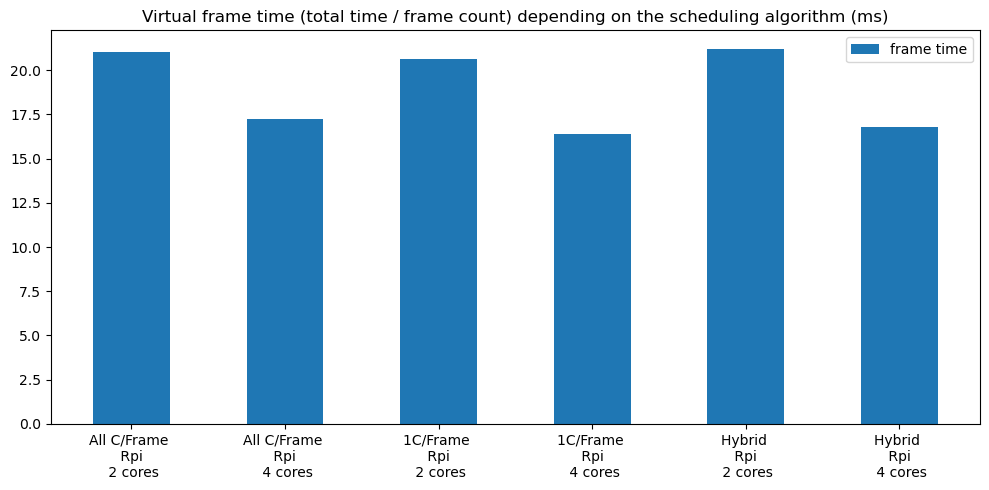

In [13]:
species = (
    "All C/Frame \n Rpi \n 2 cores",
    "All C/Frame \n Rpi \n 4 cores",
    "1C/Frame \n Rpi \n 2 cores",
    "1C/Frame \n Rpi \n 4 cores",
    "Hybrid \n Rpi \n 2 cores",
    "Hybrid \n Rpi \n 4 cores",
)
weight_counts = {
    "frame time": np.array([scheduRpi[c]["allCoresAllFrames"]["realTiming"] for c in [2, 4]] + 
                                     [scheduRpi[c]["oneCorePerFrame"]["realTiming"] for c in [2, 4]] +
                                     [scheduRpi[c]["hybrid"]["realTiming"] for c in [2, 4]])
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) depending on the scheduling algorithm (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/scheduling2.png")

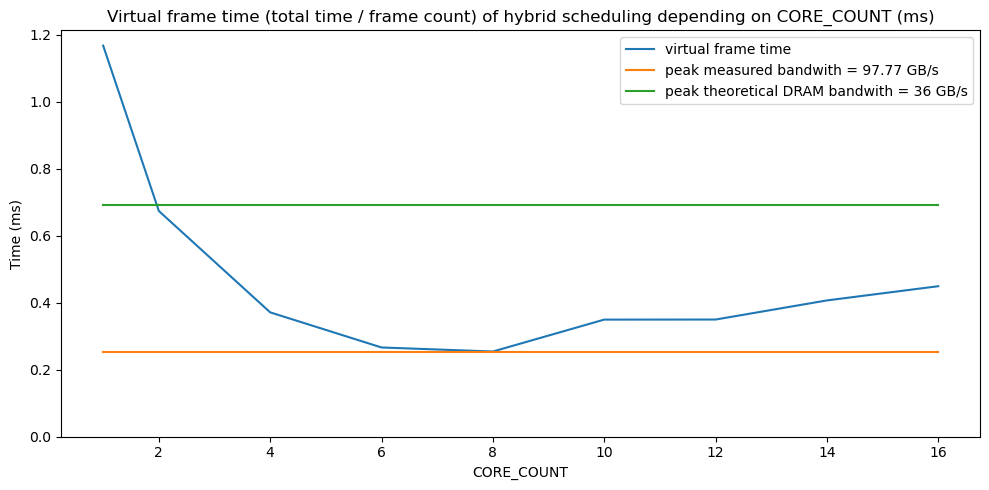

In [4]:
scheduCoreX86 = {}

with open(pathX86 + "scheduling/HYBRID_CORES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["CORE_COUNT"]) not in scheduCoreX86.keys()) :
            scheduCoreX86[int(float(row["CORE_COUNT"]))] = 0
        scheduCoreX86[int(float(row["CORE_COUNT"]))] += float(row["realTiming"])

x86x = [i for i in scheduCoreX86.keys()]
x86x.sort()
x86y = [scheduCoreX86[i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN*5) for i in x86x]

min = x86y[0]
for y in x86y:
    if y < min:
        min = y
        
bandwith = ((1 / (min / 1000))*1920*480*(3+3+6+6+2+2+2+2+1))/1000000000 

plt.figure()
plt.plot(x86x, x86y, label="virtual frame time")
plt.plot(x86x, [min for i in x86x], label="peak measured bandwith = " + "{0:.2f}".format(bandwith) + " GB/s")
plt.plot(x86x, [min*(bandwith/36) for i in x86x], label="peak theoretical DRAM bandwith = 36 GB/s")
plt.ylim(0)
plt.title("Virtual frame time (total time / frame count) of hybrid scheduling depending on CORE_COUNT (ms)")
plt.xlabel('CORE_COUNT')
plt.ylabel('Time (ms)')
plt.legend()

# plt.savefig("figures/bandwidth_x86.png")

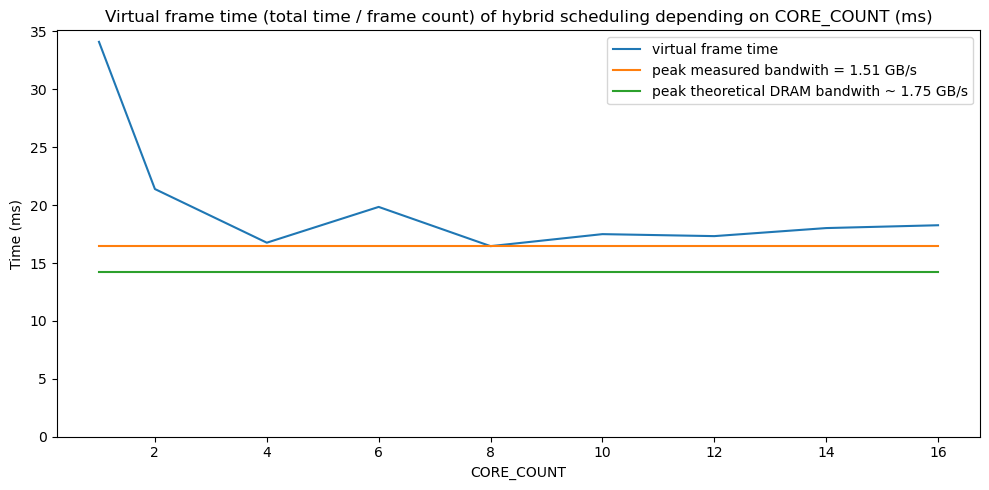

In [14]:
scheduCoreRpi = {}

with open(pathRpi + "scheduling/HYBRID_CORES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        if (int(row["CORE_COUNT"]) not in scheduCoreRpi.keys()) :
            scheduCoreRpi[int(float(row["CORE_COUNT"]))] = 0
        scheduCoreRpi[int(float(row["CORE_COUNT"]))] += float(row["realTiming"])

Rpix = [i for i in scheduCoreRpi.keys()]
Rpix.sort()
Rpiy = [scheduCoreRpi[i]/(RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI*3) for i in Rpix]
min = Rpiy[0]
for y in Rpiy:
    if y < min:
        min = y
        
bandwith = ((1 / (min / 1000))*1920*480*(3+3+6+6+2+2+2+2+1))/1000000000 

plt.figure()
plt.plot(Rpix, Rpiy, label="virtual frame time")
plt.plot(Rpix, [min for i in Rpix], label="peak measured bandwith = " + "{0:.2f}".format(bandwith) + " GB/s")
plt.plot(Rpix, [min*(bandwith/1.75) for i in Rpix], label="peak theoretical DRAM bandwith ~ 1.75 GB/s")
plt.ylim(0)
plt.title("Virtual frame time (total time / frame count) of hybrid scheduling depending on CORE_COUNT (ms)")
plt.xlabel('CORE_COUNT')
plt.ylabel('Time (ms)')
plt.legend()

# plt.savefig("figures/bandwidth.png")

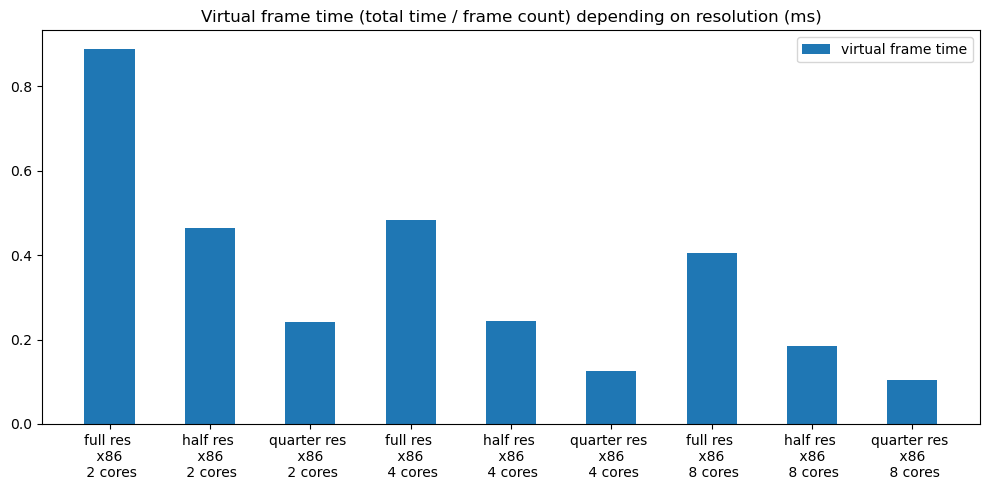

In [20]:
resX86 = {}
algos = ["full", "half", "quarter"]
for c in x86Cores:
    resX86[c] = {}
    for algo in algos:
        resX86[c][algo] = {}
        resX86[c][algo]["realTiming"] = 0.0
    
with open(pathX86 + "resolutions/FULL_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "full"
    for row in reader:
        resX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "resolutions/HALF_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "half"
    for row in reader:
        resX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "resolutions/QUARTER_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "quarter"
    for row in reader:
        resX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])

for c in x86Cores:
    for algo in algos:
        resX86[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "full res \n x86 \n 2 cores",
    "half res \n x86 \n 2 cores",
    "quarter res \n x86 \n 2 cores",
    "full res \n x86 \n 4 cores",
    "half res \n x86 \n 4 cores",
    "quarter res \n x86 \n 4 cores",
    "full res \n x86 \n 8 cores",
    "half res \n x86 \n 8 cores",
    "quarter res \n x86 \n 8 cores",
)
weight_counts = {
    "virtual frame time": np.array([resX86[2][c]["realTiming"] for c in algos] +
                           [resX86[4][c]["realTiming"] for c in algos] +
                           [resX86[8][c]["realTiming"] for c in algos]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) depending on resolution (ms)")
ax.legend(loc="upper right")

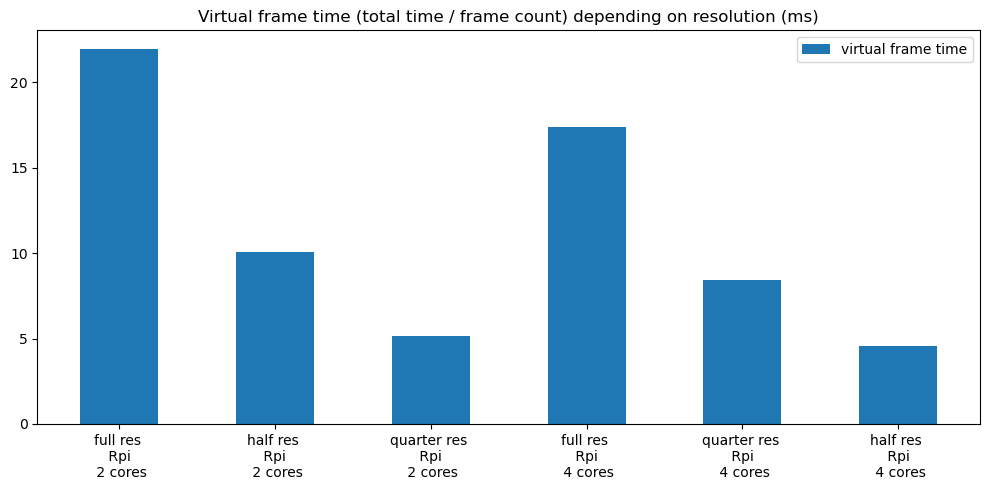

In [21]:
resRpi = {}
algos = ["full", "half", "quarter"]
for c in RpiCores:
    resRpi[c] = {}
    for algo in algos:
        resRpi[c][algo] = {}
        resRpi[c][algo]["realTiming"] = 0.0
    
with open(pathRpi + "resolutions/FULL_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "full"
    for row in reader:
        resRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "resolutions/HALF_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "half"
    for row in reader:
        resRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "resolutions/QUARTER_RES_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "quarter"
    for row in reader:
        resRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])

for c in RpiCores:
    for algo in algos:
        resRpi[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "full res \n Rpi \n 2 cores",
    "half res \n Rpi \n 2 cores",
    "quarter res \n Rpi \n 2 cores",
    "full res \n Rpi \n 4 cores",
    "quarter res \n Rpi \n 4 cores",
    "half res \n Rpi \n 4 cores",
)
weight_counts = {
    "virtual frame time": np.array([resRpi[2][c]["realTiming"] for c in algos] +
                           [resRpi[4][c]["realTiming"] for c in algos]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) depending on resolution (ms)")
ax.legend(loc="upper right")

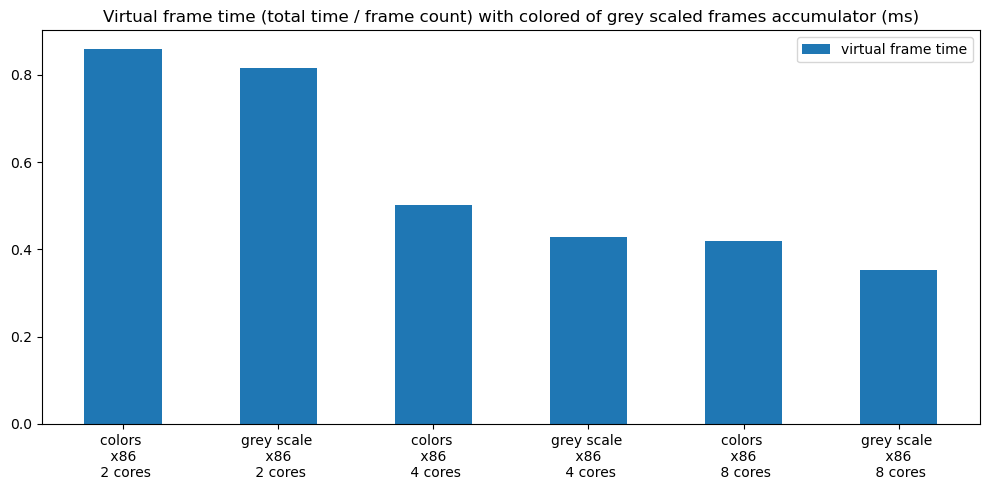

In [22]:
greyX86 = {}
algos = ["colors", "grey_scale"]
for c in x86Cores:
    greyX86[c] = {}
    for algo in algos:
        greyX86[c][algo] = {}
        greyX86[c][algo]["realTiming"] = 0.0
    
with open(pathX86 + "grey_scale/COLORS_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "colors"
    for row in reader:
        greyX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathX86 + "grey_scale/GREY_SCALE_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "grey_scale"
    for row in reader:
        greyX86[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])

for c in x86Cores:
    for algo in algos:
        greyX86[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)

species = (
    "colors \n x86 \n 2 cores",
    "grey scale \n x86 \n 2 cores",
    "colors \n x86 \n 4 cores",
    "grey scale \n x86 \n 4 cores",
    "colors \n x86 \n 8 cores",
    "grey scale \n x86 \n 8 cores",
)
weight_counts = {
    "virtual frame time": np.array([greyX86[2][c]["realTiming"] for c in algos] +
                           [greyX86[4][c]["realTiming"] for c in algos] +
                           [greyX86[8][c]["realTiming"] for c in algos]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) with colored of grey scaled frames accumulator (ms)")
ax.legend(loc="upper right")

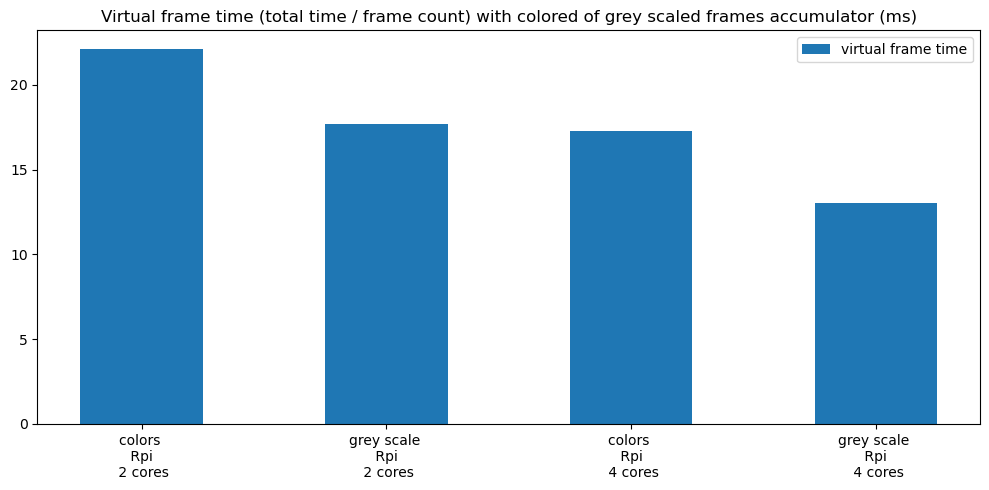

In [15]:
greyRpi = {}
algos = ["colors", "grey_scale"]
for c in RpiCores:
    greyRpi[c] = {}
    for algo in algos:
        greyRpi[c][algo] = {}
        greyRpi[c][algo]["realTiming"] = 0.0
    
with open(pathRpi + "grey_scale/COLORS_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "colors"
    for row in reader:
        greyRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])
        
with open(pathRpi + "grey_scale/GREY_SCALE_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    algo = "grey_scale"
    for row in reader:
        greyRpi[int(row["CORE_COUNT"])][algo]["realTiming"] += float(row["realTiming"])

for c in RpiCores:
    for algo in algos:
        greyRpi[c][algo]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)

species = (
    "colors \n Rpi \n 2 cores",
    "grey scale \n Rpi \n 2 cores",
    "colors \n Rpi \n 4 cores",
    "grey scale \n Rpi \n 4 cores",
)
weight_counts = {
    "virtual frame time": np.array([greyRpi[2][c]["realTiming"] for c in algos] +
                           [greyRpi[4][c]["realTiming"] for c in algos]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2*2)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) with colored of grey scaled frames accumulator (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/grey_scale.png")

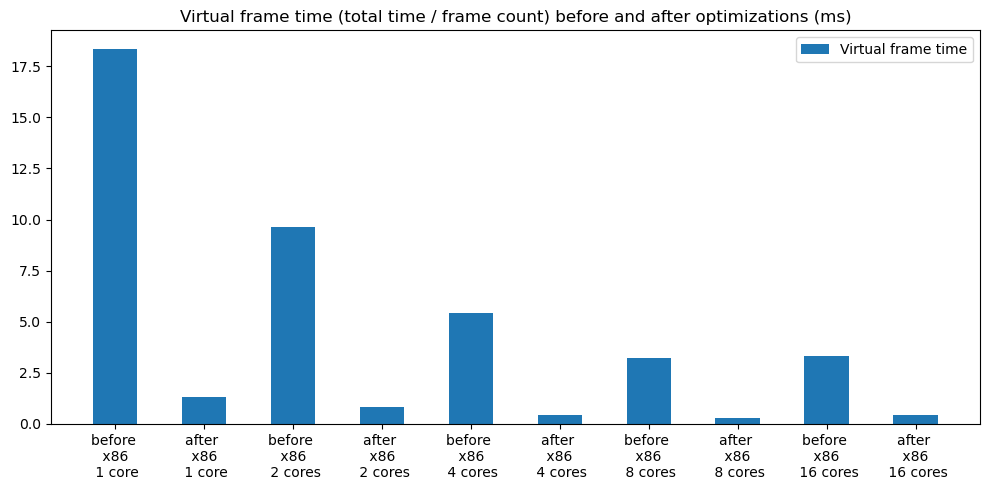

In [24]:
# final benchmark
dataFinalX86 = {}
for c in x86Cores:
    dataFinalX86[c] = {}
    dataFinalX86[c]["realTiming"] = 0.0
    
with open(pathX86 + "complete_benchmark/FINAL_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataFinalX86[int(row["CORE_COUNT"])]["realTiming"] += float(row["realTiming"])

for c in x86Cores:
    dataFinalX86[c]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN)
    
d = []
for c in x86Cores:
    d.append(dataIntroX86[c]["realTiming"])
    d.append(dataFinalX86[c]["realTiming"])
    
# species = (
#     "before \n x86 \n 1 core",
#     "before \n x86 \n 2 cores",
#     "before \n x86 \n 4 cores",
#     "before \n x86 \n 8 cores",
#     "before \n x86 \n 16 cores",
#     "after \n x86 \n 1 core",
#     "after \n x86 \n 2 cores",
#     "after \n x86 \n 4 cores",
#     "after \n x86 \n 8 cores",
#     "after \n x86 \n 16 cores",
# )
species = (
    "before \n x86 \n 1 core",
    "after \n x86 \n 1 core",
    "before \n x86 \n 2 cores",
    "after \n x86 \n 2 cores",
    "before \n x86 \n 4 cores",
    "after \n x86 \n 4 cores",
    "before \n x86 \n 8 cores",
    "after \n x86 \n 8 cores",
    "before \n x86 \n 16 cores",
    "after \n x86 \n 16 cores",
)
weight_counts = {
    "Virtual frame time": np.array(d),
#     "Virtual frame time": np.array([dataIntroX86[c]["realTiming"] for c in x86Cores] +
#                                    [dataFinalX86[c]["realTiming"] for c in x86Cores]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2*len(x86Cores))
# ax.set_yscale('log')

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) before and after optimizations (ms)")
ax.legend(loc="upper right")

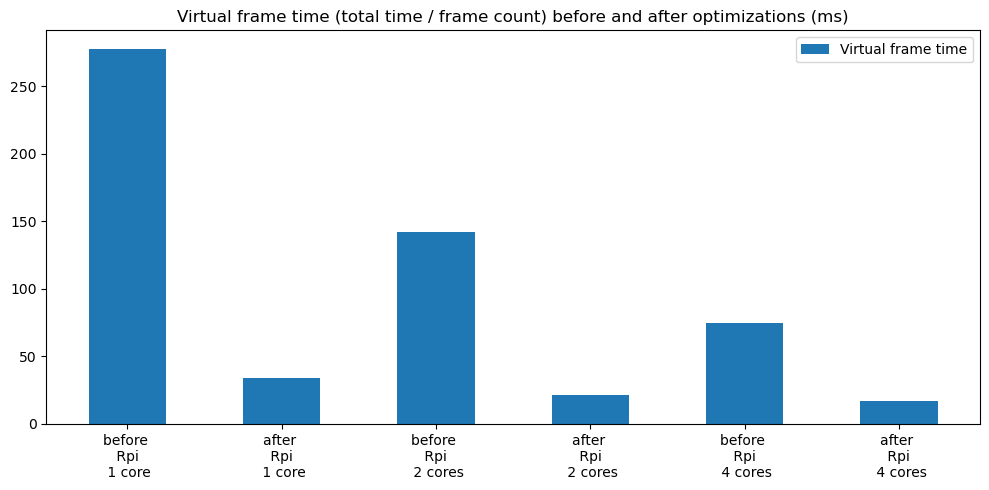

In [16]:
# fianl benchmark
dataFinalRpi = {}
for c in RpiCores:
    dataFinalRpi[c] = {}
    dataFinalRpi[c]["realTiming"] = 0.0
    
with open(pathRpi + "complete_benchmark/FINAL_totalTimings.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';')
    for row in reader:
        dataFinalRpi[int(row["CORE_COUNT"])]["realTiming"] += float(row["realTiming"])

for c in RpiCores:
    dataFinalRpi[c]["realTiming"] /= (RUNS_PER_CONFIG*FRAMES_PER_RUN_RPI)
    
d = []
for c in RpiCores:
    d.append(dataIntroRpi[c]["realTiming"])
    d.append(dataFinalRpi[c]["realTiming"])
    
species = (
    "before \n Rpi \n 1 core",
    "after \n Rpi \n 1 core",
    "before \n Rpi \n 2 cores",
    "after \n Rpi \n 2 cores",
    "before \n Rpi \n 4 cores",
    "after \n Rpi \n 4 cores",
)
weight_counts = {
    "Virtual frame time": np.array(d),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(2*len(RpiCores))

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Virtual frame time (total time / frame count) before and after optimizations (ms)")
ax.legend(loc="upper right")

# plt.savefig("figures/final.png")

In [26]:
def save_multi_image(filename):
    pp = PdfPages(filename)
    
    # first page
    firstPage = plt.figure(figsize=(8, 4))
    firstPage.clf()
    txt = 'Results of x86 benchmarks on the following platform:\n- Intel Core I7 11800H \n 8 cores\n 8x48KB L1D\n 8x1.25MB L2\n 24MB L3\n- 32GB DDR4'
    firstPage.text(0.5,0.5,txt, transform=firstPage.transFigure, size=16, ha="center")
    pp.savefig()
    
    # first page Bis
    firstPage = plt.figure(figsize=(8, 4))
    firstPage.clf()
    txt = 'Results of Raspberry pi benchmarks on the following platform:\n- Raspberry pi 3B \n 4 cores Cortex-A53 \n- 1GB DDR2'
    firstPage.text(0.5,0.5,txt, transform=firstPage.transFigure, size=16, ha="center")
    pp.savefig()
    
    # info
    secondPage = plt.figure(figsize=(8, 4))
    secondPage.clf()
    txt = 'If not specified, the following default parameters are applied:\n- input resolution: 1920*480 \n- STEP1_ACCUMULATOR_BLOC_COUNT = 16 \n- PATH_DETECTION_RADIUS = 150 \n- Scheduling policy = Hybrid'
    secondPage.text(0.5,0.5,txt, transform=secondPage.transFigure, size=16, ha="center")
    pp.savefig()

    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs[:-3]:
        fig.savefig(pp, format='pdf', bbox_inches='tight')
    pp.close()
    
filename = "benchmarks_figures.pdf"
save_multi_image(filename)

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>